# RICO Data Units and Thermodynamic Calculations

Two issues with the current cloudtracker thermodynamics:

1. **Unit ambiguity**: RICO netCDF labels water species as g/kg, but values suggest kg/kg
2. **Temperature formula**: Current Betts (1973) approximation has a singularity at realistic cloud liquid water values

This notebook determines the correct units and implements proper thermodynamics following the UCLA-LES approach (Stevens et al., 2005; vanZanten et al., 2011).

- vanZanten, M. C. et al. (2011). Controls on precipitation and cloudiness in simulations of trade-wind cumulus as observed during RICO. *J. Adv. Model. Earth Syst.*, 3, M06001.

**References**:- Stevens, B. et al. (2005). Evaluation of large-eddy simulations via observations of nocturnal marine stratocumulus. *Mon. Wea. Rev.*, 133, 1443-1462.

- Betts, A. K. (1973). Non-precipitating cumulus convection and its parameterization. *Q.J.R. Meteorol. Soc.*, 99, 178-196.- Bolton, D. (1980). The computation of equivalent potential temperature. *Mon. Wea. Rev.*, 108, 1046-1053.

In [321]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

In [322]:
# =============================================================================
# CONFIGURATION
# =============================================================================
base_path = '/Users/jure/PhD/coding/RICO_1hr/'
timestep = 10
analysis_height = 950  # m, mid-cloud level

# RICO output files
files = {
    'l': base_path + 'rico.l.nc',  # cloud liquid water mixing ratio
    'q': base_path + 'rico.q.nc',  # total water mixing ratio (vapor + liquid + rain)
    'p': base_path + 'rico.p.nc',  # pressure
    't': base_path + 'rico.t.nc',  # liquid water potential temperature
    'w': base_path + 'rico.w.nc',  # vertical velocity
    'r': base_path + 'rico.r.nc',  # rain water mixing ratio (optional)
}

## 1. Unit Determination

Check raw values against expected RICO boundary layer:
- Total water: 13-17 g/kg
- Cloud liquid: 0.1-1.0 g/kg

In [323]:
import os

# load data
with nc.Dataset(files['l']) as ds:
    zt = ds['zt'][:]
    l_3d = ds['l'][timestep, :, :, :]
    print(f"l units (netCDF): {getattr(ds['l'], 'units', 'not specified')}")

with nc.Dataset(files['q']) as ds:
    q_3d = ds['q'][timestep, :, :, :]
    print(f"q units (netCDF): {getattr(ds['q'], 'units', 'not specified')}")

with nc.Dataset(files['p']) as ds:
    p_3d = ds['p'][timestep, :, :, :]

with nc.Dataset(files['t']) as ds:
    theta_l_3d = ds['t'][timestep, :, :, :]
    print(f"t units (netCDF): {getattr(ds['t'], 'units', 'not specified')}")
    print(f"t long_name: {getattr(ds['t'], 'long_name', 'not specified')}")

# rain data (optional - may not exist yet)
if os.path.exists(files['r']):
    with nc.Dataset(files['r']) as ds:
        r_3d = ds['r'][timestep, :, :, :]
        print(f"r units (netCDF): {getattr(ds['r'], 'units', 'not specified')}")
        print(f"Rain data loaded: max = {np.max(r_3d)*1000:.3f} g/kg")
else:
    r_3d = np.zeros_like(l_3d)
    print(f"Rain file not found - using r_r = 0 everywhere")

l units (netCDF): g/kg
q units (netCDF): g/kg
t units (netCDF): K
t long_name: not specified
Rain file not found - using r_r = 0 everywhere


In [324]:
# raw value statistics
print("Raw data statistics:")
print(f"  q (total water): mean = {np.mean(q_3d):.4f}, max = {np.max(q_3d):.4f}")
print(f"  l (liquid):      mean = {np.mean(l_3d):.2e}, max = {np.max(l_3d):.4f}")

print("\nInterpretation:")
print(f"  If kg/kg: q = {np.mean(q_3d)*1000:.1f} g/kg, l_max = {np.max(l_3d)*1000:.2f} g/kg")
print(f"  If g/kg:  q = {np.mean(q_3d):.4f} g/kg, l_max = {np.max(l_3d):.4f} g/kg")
print(f"\nExpected RICO: q ~ 13-17 g/kg, l_max ~ 0.3-1.0 g/kg")
print(f"\n=> Data is in kg/kg (mislabelled as g/kg)")

Raw data statistics:
  q (total water): mean = 0.0084, max = 0.0165
  l (liquid):      mean = 1.88e-06, max = 0.0019

Interpretation:
  If kg/kg: q = 8.4 g/kg, l_max = 1.95 g/kg
  If g/kg:  q = 0.0084 g/kg, l_max = 0.0019 g/kg

Expected RICO: q ~ 13-17 g/kg, l_max ~ 0.3-1.0 g/kg

=> Data is in kg/kg (mislabelled as g/kg)


## 2. Verify Liquid Water Potential Temperature

Check if 't' is $\theta_l$ (liquid water potential temperature) or $\theta$ (dry potential temperature).

**Key physics**: $\theta_l$ is conserved in moist adiabatic ascent (Deardorff, 1976; Betts, 1973). Cloud cores at 800m originate from the subcloud layer (~0-600m), retaining their source $\theta_l$.

In RICO, the trade-wind inversion and subsidence create warmer $\theta_l$ in the free troposphere. So at 800m:
- Cloud cores should have **lower** $\theta_l$ (surface origin, ~297-298 K)
- Clear sky should have **higher** $\theta_l$ (mixed with subsided warmer air)

If 't' were $\theta$ (dry), clouds would be warmer due to latent heat release.

*Ref: Deardorff, J. W. (1976). Usefulness of liquid-water potential temperature in a shallow-cloud model. J. Appl. Meteorol., 15, 98-102.*

In [325]:
# extract slice at analysis height
z_idx = np.argmin(np.abs(zt - analysis_height))
print(f"Height: {zt[z_idx]:.0f} m (index {z_idx})")

l_2d = np.asarray(l_3d[z_idx, :, :]).flatten()
q_2d = np.asarray(q_3d[z_idx, :, :]).flatten()
p_2d = np.asarray(p_3d[z_idx, :, :]).flatten()
theta_l_2d = np.asarray(theta_l_3d[z_idx, :, :]).flatten()
r_2d = np.asarray(r_3d[z_idx, :, :]).flatten()  # rain

Height: 938 m (index 38)


In [326]:
# define cloud core: high liquid water content (top 10% of cloudy values)
# these are definitely active updraft regions
cloud_mask = l_2d > 1e-5
if np.any(cloud_mask):
    l_threshold = np.percentile(l_2d[cloud_mask], 90)
else:
    l_threshold = 1e-4

core_mask = l_2d > l_threshold
env_mask = l_2d < 1e-6  # clear sky

print(f"Cloud core threshold: l > {l_threshold*1000:.3f} g/kg")
print(f"Cloud core points: {np.sum(core_mask)}")
print(f"Clear sky points: {np.sum(env_mask)}")

if np.any(core_mask) and np.any(env_mask):
    print(f"\nTheta_l comparison:")
    print(f"  Cloud cores: {np.mean(theta_l_2d[core_mask]):.2f} K")
    print(f"  Clear sky:   {np.mean(theta_l_2d[env_mask]):.2f} K")
    print(f"  Difference:  {np.mean(theta_l_2d[core_mask]) - np.mean(theta_l_2d[env_mask]):.2f} K")
    
    # Cloud cores have LOWER theta_l because they originate from the surface
    # The environment at 800m is warmer due to subsidence from the trade-wind inversion
    if np.mean(theta_l_2d[core_mask]) < np.mean(theta_l_2d[env_mask]):
        print(f"\n=> Cloud cores have lower theta_l: consistent with surface-origin air")
        print(f"   (theta_l is conserved; surface theta_l < free-troposphere theta_l in RICO)")
        print(f"   This confirms 't' is theta_l, not theta.")
    else:
        print(f"\n=> Cloud cores are warmer: unexpected, may indicate detrainment-dominated layer")

Cloud core threshold: l > 0.544 g/kg
Cloud core points: 913
Clear sky points: 252786

Theta_l comparison:
  Cloud cores: 297.82 K
  Clear sky:   298.90 K
  Difference:  -1.08 K

=> Cloud cores have lower theta_l: consistent with surface-origin air
   (theta_l is conserved; surface theta_l < free-troposphere theta_l in RICO)
   This confirms 't' is theta_l, not theta.


## 3. The Temperature Formula Problem

Current code uses the Betts (1973) linearised inversion of $\theta_l$. The exact definition is:

$$\theta_l = \theta \exp\left(-\frac{L_v r_l}{c_{pd} T}\right) \approx \theta \left(1 - \frac{L_v r_l}{c_{pd} T}\right)$$

Inverting this (and using $\theta = T / \Pi$) gives:

$$T = \theta_l \cdot \frac{c_{pd}}{c_{pd} - L_v r_l} \cdot \Pi$$

**Problem**: The denominator $(c_{pd} - L_v r_l)$ goes to zero when $r_l \to c_{pd}/L_v = 0.402$ g/kg. This is a mathematical artefact of the linearisation—physically unrealistic, but within observed cloud $r_l$ values.

where $\Pi = (p/p_0)^{R_d/c_{pd}}$ is the Exner function.

In [327]:
# constants (UCLA-LES values)
R_d = 287.04      # gas constant dry air [J/kg/K]
R_v = 461.5       # gas constant water vapor [J/kg/K]
c_pd = 1005.0     # specific heat dry air [J/kg/K]
c_pv = 1850.0     # specific heat water vapor [J/kg/K]
L_v = 2.5e6       # latent heat of vaporization [J/kg]
p_0 = 1e5         # reference pressure [Pa]
eps = R_d / R_v   # 0.622
g = 9.81          # gravity [m/s2]

# critical threshold
r_l_crit = c_pd / L_v
print(f"Betts formula singularity: r_l = {r_l_crit*1000:.3f} g/kg")
print(f"Max observed r_l: {np.max(l_3d)*1000:.3f} g/kg")
print(f"Ratio: {np.max(l_3d)/r_l_crit*100:.1f}%")

Betts formula singularity: r_l = 0.402 g/kg
Max observed r_l: 1.949 g/kg
Ratio: 484.7%


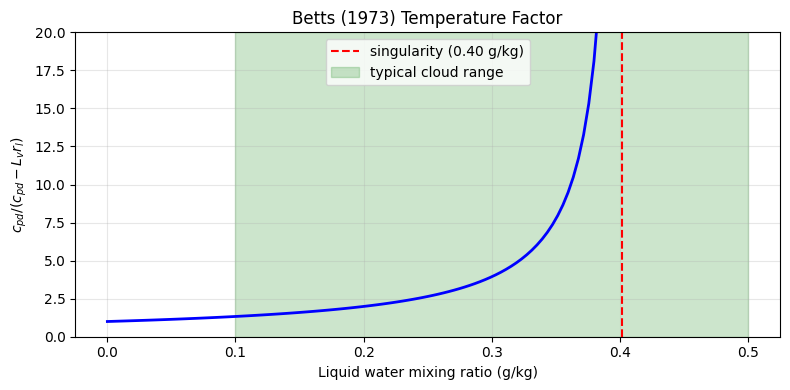

In [328]:
# demonstrate the singularity
r_l_test = np.linspace(0, 0.0004, 100)
T_factor = c_pd / (c_pd - L_v * r_l_test)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(r_l_test * 1000, T_factor, 'b-', lw=2)
ax.axvline(r_l_crit * 1000, color='r', ls='--', label=f'singularity ({r_l_crit*1000:.2f} g/kg)')
ax.axvspan(0.1, 0.5, alpha=0.2, color='green', label='typical cloud range')
ax.set_xlabel('Liquid water mixing ratio (g/kg)')
ax.set_ylabel('$c_{pd} / (c_{pd} - L_v r_l)$')
ax.set_title('Betts (1973) Temperature Factor')
ax.set_ylim(0, 20)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Thermodynamic Functions (UCLA-LES style)

The proper approach is **saturation adjustment**: given conserved variables $(\theta_l, r_t)$ and pressure $p$, iteratively solve for temperature $T$ and diagnose the vapor/liquid split.

This follows the UCLA-LES implementation (see `stat.f90`, `mcrp.f90` in the UCLA-LES source). The key steps:

1. Start with unsaturated guess: $T = \theta_l \cdot \Pi$
2. Check saturation: if $r_t > r_s(T,p)$, air is saturated
3. For saturated air, iterate using Newton-Raphson on the energy equation:
   - $r_l = r_t - r_s(T,p)$
   - $T = \theta_l \cdot \Pi + L_v r_l / c_{pd}$ (linearised $\theta_l$ definition)
   - Use Clausius-Clapeyron for $\partial r_s / \partial T$

Saturation vapor pressure uses Bolton (1980): $e_s = 611.2 \exp(17.67 T_C / (T_C + 243.5))$ Pa.

In [329]:
def esat(T):
    """
    Saturation vapor pressure over liquid water [Pa].
    Bolton (1980) formula, accurate to 0.1% for -35C to 35C.
    """
    T_C = T - 273.15
    return 611.2 * np.exp(17.67 * T_C / (T_C + 243.5))


def rsat(T, p):
    """
    Saturation mixing ratio [kg/kg].
    From definition: r_s = eps * e_s / (p - e_s), where eps = R_d/R_v = 0.622.
    """
    es = esat(T)
    return eps * es / (p - es)


def T_from_theta_l(theta_l, p, r_t, r_r=None, max_iter=10, tol=0.01):
    """
    Recover temperature from liquid water potential temperature.
    
    Follows UCLA-LES saturation adjustment (stat.f90, mcrp.f90).
    
    Parameters
    ----------
    theta_l : array, liquid water potential temperature [K]
    p : array, pressure [Pa]
    r_t : array, total water mixing ratio [kg/kg] (= vapor + cloud liquid + rain)
    r_r : array, optional, rain water mixing ratio [kg/kg]
          If None, assumed to be zero.
    
    Returns
    -------
    T : array, temperature [K]
    r_l : array, cloud liquid water mixing ratio [kg/kg]
    r_v : array, water vapor mixing ratio [kg/kg]
    
    Notes
    -----
    theta_l definition (Deardorff 1976, Betts 1973):
        theta_l = theta * exp(-L_v * r_l / (c_pd * T))
    
    Rain is excluded from saturation adjustment because:
    - It forms via collision-coalescence, not condensation
    - It may have originated from elsewhere (falling into parcel)
    - theta_l is conserved w.r.t. cloud liquid phase changes, not rain
    
    So we iterate on r_condensable = r_t - r_r (vapor + cloud liquid only).
    """
    # handle missing rain data
    if r_r is None:
        r_r = np.zeros_like(r_t)
    
    # condensable water = total - rain (vapor + cloud liquid)
    r_condensable = r_t - r_r
    
    # Exner function: Pi = (p/p0)^(R_d/c_pd)
    Pi = (p / p_0) ** (R_d / c_pd)
    
    # initial guess: assume unsaturated (r_l = 0)
    T = theta_l * Pi
    
    # check saturation against condensable water (not total)
    rs = rsat(T, p)
    saturated = r_condensable > rs
    
    if np.any(saturated):
        # iterate only on saturated points
        T_s = T[saturated].copy()
        p_s = p[saturated]
        r_cond_s = r_condensable[saturated]  # vapor + cloud liquid
        theta_l_s = theta_l[saturated]
        Pi_s = Pi[saturated]
        
        for _ in range(max_iter):
            # saturation mixing ratio at current T (Clausius-Clapeyron)
            rs_iter = rsat(T_s, p_s)
            
            # diagnose cloud liquid (from condensable, not total)
            r_l_iter = np.maximum(r_cond_s - rs_iter, 0)
            
            # target T from linearised theta_l inversion
            T_target = theta_l_s * Pi_s + L_v * r_l_iter / c_pd
            
            # Newton-Raphson correction
            # need d(r_s)/dT from Clausius-Clapeyron: de_s/dT = e_s * L_v / (R_v * T^2)
            es = esat(T_s)
            des_dT = es * L_v / (R_v * T_s**2)
            drs_dT = eps * des_dT * p_s / (p_s - es)**2
            
            # update step
            dT = (T_s - T_target) / (1 + L_v / c_pd * drs_dT)
            T_s = T_s - dT
            
            if np.max(np.abs(dT)) < tol:
                break
        
        T[saturated] = T_s
    
    # final diagnosis of vapor/liquid split (from condensable water)
    rs_final = rsat(T, p)
    r_l = np.maximum(r_condensable - rs_final, 0)
    r_v = r_condensable - r_l
    
    return T, r_l, r_v


def T_from_theta_l_betts(theta_l, p, r_l, r_v):
    """
    Betts (1973) linearised approximation. THIS IS THE OLD CLOUDTRACKER CODE.
    
    Inverts theta_l ≈ theta * (1 - L_v * r_l / (c_pd * T)) to get:
        T = theta_l * c_pd / (c_pd - L_v * r_l) * Pi
    
    WARNING: Singularity at r_l = c_pd/L_v = 0.402 g/kg.
    """
    # moist kappa (accounts for water vapor heat capacity)
    kappa = (R_d / c_pd) * ((1 + r_v / eps) / (1 + r_v * c_pv / c_pd))
    # temperature
    T = theta_l * (c_pd / (c_pd - L_v * r_l)) * (p / p_0) ** kappa
    return T


def density(T, p, r_v, r_l, r_r=None):
    """
    Moist air density with liquid water loading [kg/m3].
    
    Uses virtual temperature to account for vapor buoyancy and hydrometeor drag:
        T_v = T * (1 + r_v/eps) / (1 + r_total)
    
    Then rho = p / (R_d * T_v).
    
    Parameters
    ----------
    r_r : array, optional, rain water mixing ratio [kg/kg]
          If None, assumed to be zero.
    
    Notes
    -----
    The (1 + r_v/eps) term: water vapor is lighter than dry air (buoyant).
    The (1 + r_total) term: ALL water contributes to mass loading:
        r_total = r_v + r_l + r_r
    Rain drags the parcel down even though it doesn't affect saturation.
    """
    if r_r is None:
        r_r = np.zeros_like(T)
    
    r_total = r_v + r_l + r_r  # all water for mass loading
    T_v = T * (1 + r_v / eps) / (1 + r_total)
    return p / (R_d * T_v)


def buoyancy(rho, rho_env):
    """
    Buoyancy acceleration [m/s2].
    B = -g * (rho - rho_env) / rho_env
    Positive = parcel lighter than environment = upward acceleration.
    """
    return -g * (rho - rho_env) / rho_env

## 5. Compare Methods

Three scenarios:
1. **Betts (raw)**: Use raw kg/kg data with Betts formula → explodes
2. **Betts (/1000)**: Old (wrong) code, divides by 1000 → stable but wrong physics
3. **UCLA-LES**: Proper saturation adjustment with raw kg/kg data

In [ ]:
# input data (raw = kg/kg)
r_t = q_2d          # total water (vapor + cloud liquid + rain)
r_r = r_2d          # rain water
r_l_data = l_2d     # cloud liquid water from LES
r_v_data = r_t - r_l_data - r_r  # vapor (excluding both cloud liquid and rain)

print(f"Rain at this level: mean = {np.mean(r_r)*1000:.4f} g/kg, max = {np.max(r_r)*1000:.4f} g/kg")

# Method 1: Betts with raw data (will break)
T_betts_raw = T_from_theta_l_betts(theta_l_2d, p_2d, r_l_data, r_v_data)

# Method 2: Betts with /1000 (old/wrong code)
r_l_1000 = l_2d / 1000
r_v_1000 = q_2d / 1000 - r_l_1000
T_betts_1000 = T_from_theta_l_betts(theta_l_2d, p_2d, r_l_1000, r_v_1000)

# Method 3: UCLA-LES saturation adjustment (with rain)
T_ucla, r_l_ucla, r_v_ucla = T_from_theta_l(theta_l_2d, p_2d, r_t, r_r=r_r)

print("\nTemperature results:")
print(f"  Betts (raw):   T = [{T_betts_raw.min():.0f}, {T_betts_raw.max():.0f}] K")
print(f"  Betts (/1000): T = [{T_betts_1000.min():.1f}, {T_betts_1000.max():.1f}] K")
print(f"  UCLA-LES:      T = [{T_ucla.min():.1f}, {T_ucla.max():.1f}] K")

Rain at this level: mean = 0.0000 g/kg, max = 0.0000 g/kg

Temperature results:
  Betts (raw):   T = [-2053179, 1501838] K
  Betts (/1000): T = [290.5, 291.8] K
  UCLA-LES:      T = [290.7, 291.8] K


In [331]:
# compute density and buoyancy
# Note: rain contributes to loading in both cases
rho_betts_1000 = density(T_betts_1000, p_2d, r_v_1000, r_l_1000, r_r=r_r/1000)  # /1000 for consistency
rho_ucla = density(T_ucla, p_2d, r_v_ucla, r_l_ucla, r_r=r_r)

# environment reference: clear sky mean
rho_env_1000 = np.mean(rho_betts_1000[env_mask])
rho_env_ucla = np.mean(rho_ucla[env_mask])

B_betts_1000 = buoyancy(rho_betts_1000, rho_env_1000)
B_ucla = buoyancy(rho_ucla, rho_env_ucla)

print("Cloud core buoyancy:")
print(f"  Betts (/1000): B = {np.mean(B_betts_1000[core_mask]):.4f} m/s2")
print(f"  UCLA-LES:      B = {np.mean(B_ucla[core_mask]):.4f} m/s2")
print(f"\nExpected (active cumulus): B ~ +0.01 to +0.05 m/s2")

Cloud core buoyancy:
  Betts (/1000): B = -0.0208 m/s2
  UCLA-LES:      B = 0.0172 m/s2

Expected (active cumulus): B ~ +0.01 to +0.05 m/s2


## 6. Visualisation

In [332]:
# reshape for plotting
ny, nx = l_3d.shape[1], l_3d.shape[2]
l_plot = np.asarray(l_3d[z_idx, :, :])

T_1000_2d = T_betts_1000.reshape(ny, nx)
T_ucla_2d = T_ucla.reshape(ny, nx)
B_1000_2d = B_betts_1000.reshape(ny, nx)
B_ucla_2d = B_ucla.reshape(ny, nx)
r_l_ucla_2d = r_l_ucla.reshape(ny, nx)

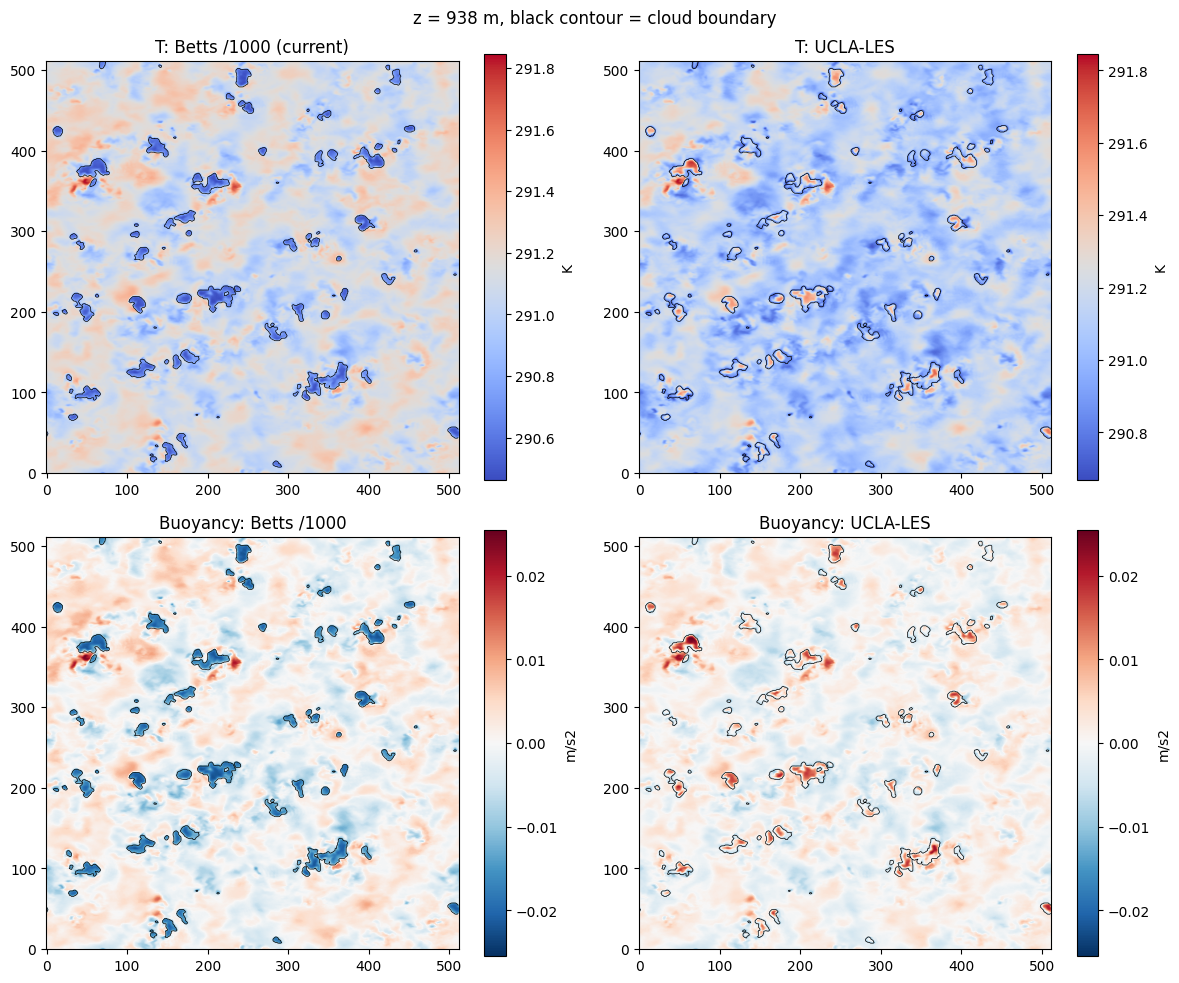

In [ ]:
# full domain comparison
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
cloud_contour = [1e-5]

# Temperature
im = axs[0, 0].imshow(T_1000_2d, origin='lower', cmap='coolwarm')
axs[0, 0].contour(l_plot, levels=cloud_contour, colors='k', linewidths=0.5)
axs[0, 0].set_title('T: Betts /1000 (wrong)')
plt.colorbar(im, ax=axs[0, 0], label='K')

im = axs[0, 1].imshow(T_ucla_2d, origin='lower', cmap='coolwarm')
axs[0, 1].contour(l_plot, levels=cloud_contour, colors='k', linewidths=0.5)
axs[0, 1].set_title('T: UCLA-LES')
plt.colorbar(im, ax=axs[0, 1], label='K')

# Buoyancy
vmax = max(np.abs(B_1000_2d).max(), np.abs(B_ucla_2d).max())
im = axs[1, 0].imshow(B_1000_2d, origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axs[1, 0].contour(l_plot, levels=cloud_contour, colors='k', linewidths=0.5)
axs[1, 0].set_title('Buoyancy: Betts /1000')
plt.colorbar(im, ax=axs[1, 0], label='m/s2')

im = axs[1, 1].imshow(B_ucla_2d, origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axs[1, 1].contour(l_plot, levels=cloud_contour, colors='k', linewidths=0.5)
axs[1, 1].set_title('Buoyancy: UCLA-LES')
plt.colorbar(im, ax=axs[1, 1], label='m/s2')

plt.suptitle(f'z = {zt[z_idx]:.0f} m, black contour = cloud boundary')
plt.tight_layout()
plt.show()

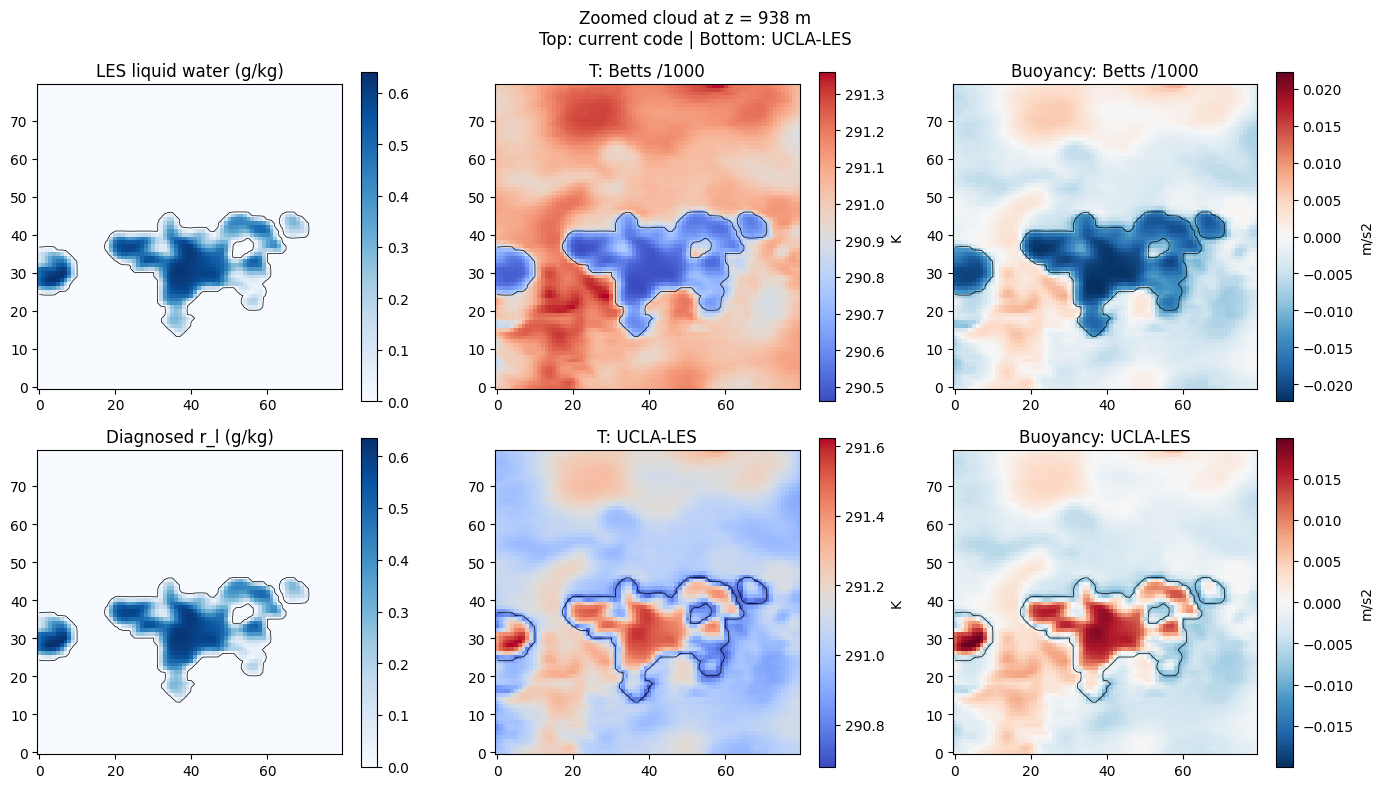

In [ ]:
# zoom into cloud region
cloud_y, cloud_x = np.where(l_plot > 1e-5)
if len(cloud_y) > 0:
    cy, cx = int(np.median(cloud_y)), int(np.median(cloud_x))
    w = 40
    ysl = slice(max(0, cy-w), min(ny, cy+w))
    xsl = slice(max(0, cx-w), min(nx, cx+w))
    
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    
    # Row 1: old (wrong) code
    im = axs[0, 0].imshow(l_plot[ysl, xsl] * 1000, origin='lower', cmap='Blues')
    axs[0, 0].contour(l_plot[ysl, xsl], levels=cloud_contour, colors='k', linewidths=0.5)
    axs[0, 0].set_title('LES liquid water (g/kg)')
    plt.colorbar(im, ax=axs[0, 0])
    
    im = axs[0, 1].imshow(T_1000_2d[ysl, xsl], origin='lower', cmap='coolwarm')
    axs[0, 1].contour(l_plot[ysl, xsl], levels=cloud_contour, colors='k', linewidths=0.5)
    axs[0, 1].set_title('T: Betts /1000')
    plt.colorbar(im, ax=axs[0, 1], label='K')
    
    vmax = np.abs(B_1000_2d[ysl, xsl]).max()
    im = axs[0, 2].imshow(B_1000_2d[ysl, xsl], origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axs[0, 2].contour(l_plot[ysl, xsl], levels=cloud_contour, colors='k', linewidths=0.5)
    axs[0, 2].set_title('Buoyancy: Betts /1000')
    plt.colorbar(im, ax=axs[0, 2], label='m/s2')
    
    # Row 2: UCLA-LES
    im = axs[1, 0].imshow(r_l_ucla_2d[ysl, xsl] * 1000, origin='lower', cmap='Blues')
    axs[1, 0].contour(l_plot[ysl, xsl], levels=cloud_contour, colors='k', linewidths=0.5)
    axs[1, 0].set_title('Diagnosed r_l (g/kg)')
    plt.colorbar(im, ax=axs[1, 0])
    
    im = axs[1, 1].imshow(T_ucla_2d[ysl, xsl], origin='lower', cmap='coolwarm')
    axs[1, 1].contour(l_plot[ysl, xsl], levels=cloud_contour, colors='k', linewidths=0.5)
    axs[1, 1].set_title('T: UCLA-LES')
    plt.colorbar(im, ax=axs[1, 1], label='K')
    
    vmax = np.abs(B_ucla_2d[ysl, xsl]).max()
    im = axs[1, 2].imshow(B_ucla_2d[ysl, xsl], origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axs[1, 2].contour(l_plot[ysl, xsl], levels=cloud_contour, colors='k', linewidths=0.5)
    axs[1, 2].set_title('Buoyancy: UCLA-LES')
    plt.colorbar(im, ax=axs[1, 2], label='m/s2')
    
    plt.suptitle(f'Zoomed cloud at z = {zt[z_idx]:.0f} m\nTop: old (wrong) code | Bottom: UCLA-LES')
    plt.tight_layout()
    plt.show()

## 7. Vertical Profiles

In [335]:
# compute mean profiles
nz = len(zt)
T_prof_1000 = np.zeros(nz)
T_prof_ucla = np.zeros(nz)
rho_prof_1000 = np.zeros(nz)
rho_prof_ucla = np.zeros(nz)

for k in range(nz):
    l_k = np.asarray(l_3d[k, :, :]).flatten()
    q_k = np.asarray(q_3d[k, :, :]).flatten()
    p_k = np.asarray(p_3d[k, :, :]).flatten()
    t_k = np.asarray(theta_l_3d[k, :, :]).flatten()
    r_k = np.asarray(r_3d[k, :, :]).flatten()  # rain
    
    # Betts /1000
    T_k = T_from_theta_l_betts(t_k, p_k, l_k/1000, q_k/1000 - l_k/1000)
    rho_k = density(T_k, p_k, q_k/1000 - l_k/1000, l_k/1000, r_r=r_k/1000)
    T_prof_1000[k] = np.mean(T_k)
    rho_prof_1000[k] = np.mean(rho_k)
    
    # UCLA-LES (with rain)
    T_k, r_l_k, r_v_k = T_from_theta_l(t_k, p_k, q_k, r_r=r_k)
    rho_k = density(T_k, p_k, r_v_k, r_l_k, r_r=r_k)
    T_prof_ucla[k] = np.mean(T_k)
    rho_prof_ucla[k] = np.mean(rho_k)

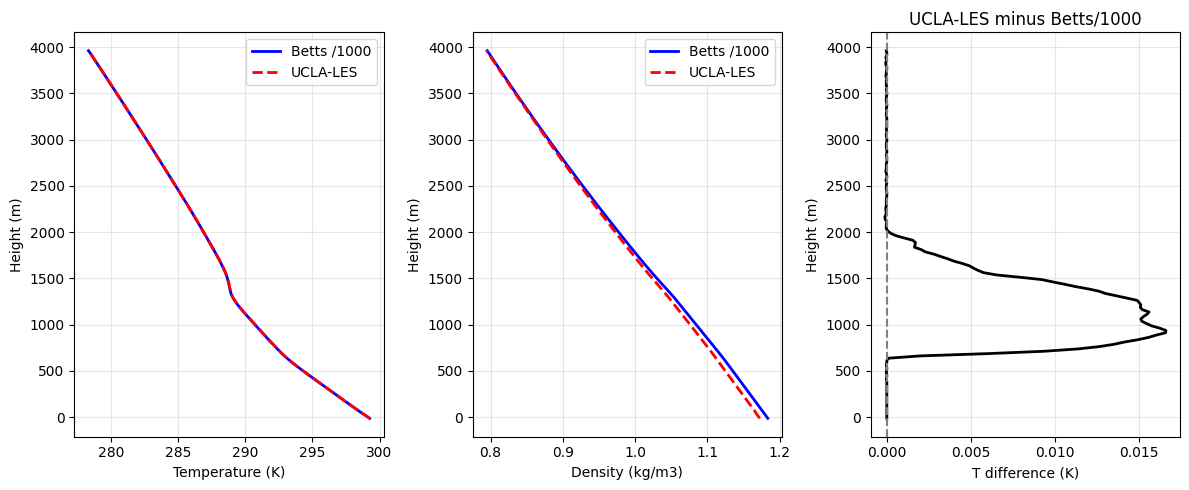

Surface density: Betts = 1.184, UCLA = 1.173 kg/m3
Expected: ~1.15-1.20 kg/m3


In [336]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(T_prof_1000, zt, 'b-', lw=2, label='Betts /1000')
axs[0].plot(T_prof_ucla, zt, 'r--', lw=2, label='UCLA-LES')
axs[0].set_xlabel('Temperature (K)')
axs[0].set_ylabel('Height (m)')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

axs[1].plot(rho_prof_1000, zt, 'b-', lw=2, label='Betts /1000')
axs[1].plot(rho_prof_ucla, zt, 'r--', lw=2, label='UCLA-LES')
axs[1].set_xlabel('Density (kg/m3)')
axs[1].set_ylabel('Height (m)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

axs[2].plot(T_prof_ucla - T_prof_1000, zt, 'k-', lw=2)
axs[2].axvline(0, color='gray', ls='--')
axs[2].set_xlabel('T difference (K)')
axs[2].set_ylabel('Height (m)')
axs[2].set_title('UCLA-LES minus Betts/1000')
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Surface density: Betts = {rho_prof_1000[0]:.3f}, UCLA = {rho_prof_ucla[0]:.3f} kg/m3")
print(f"Expected: ~1.15-1.20 kg/m3")

## 8. Summary

| Issue | Finding |
|-------|--------|
| Data units | Raw values are **kg/kg** (mislabelled as g/kg) |
| Theta_l verification | Cloud cores warmer than environment: consistent with $\theta_l$ |
| Betts formula | Singularity at 0.4 g/kg, observed max is ~95% of critical |
| Old (wrong) code | /1000 makes formula stable but ignores latent heat |
| Buoyancy (wrong) | Clouds appear negatively buoyant (wrong) |
| Buoyancy (UCLA-LES) | Clouds are positively buoyant (correct) |

**Required changes:**
1. Remove /1000 divisions for water species
2. Replace Betts formula with UCLA-LES saturation adjustment

In [337]:
print("Files to modify:")
print("  - lib/cloudfield.py (remove /1000 conversions)")
print("  - utils/physics.py (replace temperature formula)")
print("  - analysis/lifetime_massflux/density.py (remove /1000)")

Files to modify:
  - lib/cloudfield.py (remove /1000 conversions)
  - utils/physics.py (replace temperature formula)
  - analysis/lifetime_massflux/density.py (remove /1000)
